<a href="https://colab.research.google.com/github/vubanc/EV_Preference_MachineLearning/blob/main/K-Modes%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-modes clustering (without built-in functions)

### Importing libraries and dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np

import random
import statistics
import math
from scipy.spatial.distance import hamming
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
from scipy.spatial.distance import cdist

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score

from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Work/EV_Preference_MachineLearning/K-modes Input.csv")

In [ ]:
df.head()

,HOUSEID,TDTRPNUM,VEHID,PERSONID,HOMEOWN,HHSIZE,HHFAMINC,DRVRCNT,WRKCOUNT,YOUNGCHILD,...,WHYTO_CAT,DWELTIME,DWELTIME_CAT,TRPMILES,TRPMILES_CAT,NUMONTRP,NUMONTRP_CAT,GASPRICE,GASPRICE_USD,FUELTYPE_BIN
0,30000775,1,2,2,1,2,2,2,0,0,...,Social & recreational,53,50-150 minutes,3.820,2-5 miles,1,1 passenger,220.3,2.203,1
1,30000775,3,1,1,1,2,2,2,0,0,...,Errands,15,1-15 minutes,1.760,0-2 miles,1,1 passenger,220.3,2.203,3
2,30000775,3,2,2,1,2,2,2,0,0,...,Shopping & Dining,10,1-15 minutes,1.188,0-2 miles,1,1 passenger,220.3,2.203,1
3,30000775,2,2,2,1,2,2,2,0,0,...,Shopping & Dining,25,15-50 minutes,3.676,2-5 miles,1,1 passenger,220.3,2.203,1
4,30000775,1,1,1,1,2,2,2,0,0,...,Social & recreational,130,50-150 minutes,3.820,2-5 miles,1,1 passenger,220.3,2.203,3


In [ ]:
df.columns

Index(['HOUSEID', 'TDTRPNUM', 'VEHID', 'PERSONID', 'HOMEOWN', 'HHSIZE',
       'HHFAMINC', 'DRVRCNT', 'WRKCOUNT', 'YOUNGCHILD', 'LIF_CYC_CAT', 'R_AGE',
       'EDUC', 'R_SEX', 'WORKER', 'HTPPOPDN', 'HTEEMPDN', 'HBPPOPDN',
       'OTEEMPDN', 'OBPPOPDN', 'DTEEMPDN', 'DBPPOPDN', 'TDWKND',
       'STRTTIME_CAT', 'TRIPPURP_CAT', 'WHYTO_CAT', 'DWELTIME', 'DWELTIME_CAT',
       'TRPMILES', 'TRPMILES_CAT', 'NUMONTRP', 'NUMONTRP_CAT', 'GASPRICE',
       'GASPRICE_USD', 'FUELTYPE_BIN'],
      dtype='object')

In [ ]:
df_cat=df[["TDWKND", "STRTTIME_CAT", "NUMONTRP_CAT", "DWELTIME_CAT", "TRPMILES_CAT", "WHYTO_CAT", "TRIPPURP_CAT"]]

In [ ]:
df_cat.shape

(19825, 7)

In [ ]:
assert(len(df_cat["TDWKND"].unique())==2)
assert(len(df_cat["STRTTIME_CAT"].unique())==5)
assert(len(df_cat["NUMONTRP_CAT"].unique())==3)
assert(len(df_cat["DWELTIME_CAT"].unique())==4)
assert(len(df_cat["TRPMILES_CAT"].unique())==4)
assert(len(df_cat["WHYTO_CAT"].unique())==5)
assert(len(df_cat["TRIPPURP_CAT"].unique())==2)

In [ ]:
df_cat.head()

,TDWKND,STRTTIME_CAT,NUMONTRP_CAT,DWELTIME_CAT,TRPMILES_CAT,WHYTO_CAT,TRIPPURP_CAT
0,Weekday trip,10 AM - 3 PM,1 passenger,50-150 minutes,2-5 miles,Social & recreational,Home based trip
1,Weekday trip,3 PM - 7 PM,1 passenger,1-15 minutes,0-2 miles,Errands,Home based trip
2,Weekday trip,10 AM - 3 PM,1 passenger,1-15 minutes,0-2 miles,Shopping & Dining,non-home based trip
3,Weekday trip,10 AM - 3 PM,1 passenger,15-50 minutes,2-5 miles,Shopping & Dining,non-home based trip
4,Weekday trip,6 AM - 10 AM,1 passenger,50-150 minutes,2-5 miles,Social & recreational,Home based trip


### Defining necessary functions

In [ ]:
def cao(dataframe, number_of_clusters):
    centroid_rows = []

    variables = list(dataframe.columns)
    temp_df = dataframe.apply(le.fit_transform)
    distanceArray = cdist(temp_df, temp_df, "hamming")*len(variables)
    similarArray = np.subtract(7,distanceArray)
    densityArray = (np.sum(similarArray, axis=0))/(len(variables)*len(dataframe))
    dataframe ["DENSITY"] = densityArray

    centroid_rows.append(np.argmax(dataframe["DENSITY"]))

    for i in range (2,number_of_clusters+1):
        dataframe ["MIN_DISTANCE"] = np.min(cdist(temp_df, temp_df.loc[(row for row in centroid_rows), :], "hamming")*len(variables), axis=1)
        dataframe["DENISTY x MIN_DISTANCE"] = dataframe["DENSITY"]*dataframe ["MIN_DISTANCE"]
        centroid_rows.append(np.argmax(dataframe["DENISTY x MIN_DISTANCE"]))

    try:
        dataframe.drop(["DENSITY", 'MIN_DISTANCE', 'DENISTY x MIN_DISTANCE'], axis=1, inplace=True)
    except:
        dataframe.drop(["DENSITY"], axis=1, inplace=True)

    return centroid_rows


def cluster_init(dataframe, number_of_clusters, init="random"):
    #Initializing centroid rows
    if init=="random":
        centroid_rows=random.sample(range(0,len(dataframe)),number_of_clusters)
    else:
        centroid_rows=init(dataframe, number_of_clusters)

    #centroid_rows.sort()
    dataframe.assign(CLUSTER=None)
    for index, row in enumerate(centroid_rows):
        dataframe.loc[row,"CLUSTER"]=index+1
    variables=list(dataframe.columns)[0:-1]  #The last variable is the "CLUSTER" variable. Hence, it is excluded.

    #Reduce the time complexity of this block
    tempDataframe = dataframe.apply(le.fit_transform)
    distanceMatrix = cdist(tempDataframe.loc[0:,variables], tempDataframe.loc[(p for p in centroid_rows),variables], metric="hamming")*len(variables)
    dataframe["CLUSTER"] = np.argmin(distanceMatrix, axis=1)+1

    return dataframe

def cluster_reassign(dataframe):
    tempDataframe = df_cat.apply(le.fit_transform)
    clusters=sorted(list(dataframe["CLUSTER"].unique()))
    variables=list(dataframe.columns)[0:-1] #The last variable is the "CLUSTER" variable. Hence, it is excluded
    centroids={}
    numCentroids=[]

    #Reassigning centroids for each of the clusters
    for i in clusters:
        temporary_dataframe=dataframe[dataframe["CLUSTER"]==i]
        num_temporary_dataframe=tempDataframe[tempDataframe["CLUSTER"]==i-1]
        centroid = []
        numCentroid = []
        for variable in variables:
            centroid.append(statistics.mode(temporary_dataframe[variable]))
            numCentroid.append(statistics.mode(num_temporary_dataframe[variable]))
        centroids[i]=centroid
        numCentroids.append(numCentroid)

    #Reduce the time complexity of this block
    dfNumCentroids = pd.DataFrame(numCentroids)
    dfNumCentroids.columns = variables

    distanceMatrix = cdist(tempDataframe.loc[0:,variables], dfNumCentroids.loc[0:,variables], metric="hamming")*len(variables)

    newClusters= np.argmin(distanceMatrix, axis=1)+1

    changes = hamming(list(newClusters), list(dataframe["CLUSTER"]))*len(dataframe["CLUSTER"])
    cost = np.sum(np.min(distanceMatrix, axis=1))

    dataframe.loc[0:,"CLUSTER"] = newClusters

    return changes, cost, centroids, numCentroids

### Running the models

In [ ]:
costs=[] #List of costs for the elbow plot
dataframes={} #The dictionary of different clustering outputs. This will help in choosing the best output from the elbow plot.
centroids = defaultdict(list)
centroids_encoded = defaultdict(list)

for num_of_clusters in range(1,16):
    df_cat = df[["TDWKND", "STRTTIME_CAT", "NUMONTRP_CAT", "DWELTIME_CAT", "TRPMILES_CAT", "WHYTO_CAT", "TRIPPURP_CAT"]]
    df_cat=cluster_init(df_cat, num_of_clusters, cao) #Initialize new clusters
    iteration_number=0
    print("Running K-modes clustering with %d cluster(s)" % num_of_clusters)
    change=np.inf
    while change>0:
        iteration_number+=1
        print("Iteration: ", iteration_number)
        change, cost, centroids[num_of_clusters], centroids_encoded[num_of_clusters] = cluster_reassign(df_cat)
        print("Number of cluster reassignments: ", change)
        print("Cost: ", cost)
    costs.append(cost)
    dataframes[num_of_clusters]=df_cat.copy(deep=True) #Adds the dataframe to the dictionary of different clustering outputs
    print("\n")

Running K-modes clustering with 1 cluster(s)
Iteration:  1
Number of cluster reassignments:  0.0
Cost:  75537.0


Running K-modes clustering with 2 cluster(s)
Iteration:  1
Number of cluster reassignments:  1699.0
Cost:  61039.0
Iteration:  2
Number of cluster reassignments:  1568.0
Cost:  60398.0
Iteration:  3
Number of cluster reassignments:  0.0
Cost:  60398.0


Running K-modes clustering with 3 cluster(s)
Iteration:  1
Number of cluster reassignments:  0.0
Cost:  58399.0


Running K-modes clustering with 4 cluster(s)
Iteration:  1
Number of cluster reassignments:  0.0
Cost:  55691.0


Running K-modes clustering with 5 cluster(s)
Iteration:  1
Number of cluster reassignments:  3654.0
Cost:  50385.0
Iteration:  2
Number of cluster reassignments:  1382.0
Cost:  48740.0
Iteration:  3
Number of cluster reassignments:  1018.0
Cost:  48196.0
Iteration:  4
Number of cluster reassignments:  0.0
Cost:  48196.0


Running K-modes clustering with 6 cluster(s)
Iteration:  1
Number of cluster rea

### Finding the best model

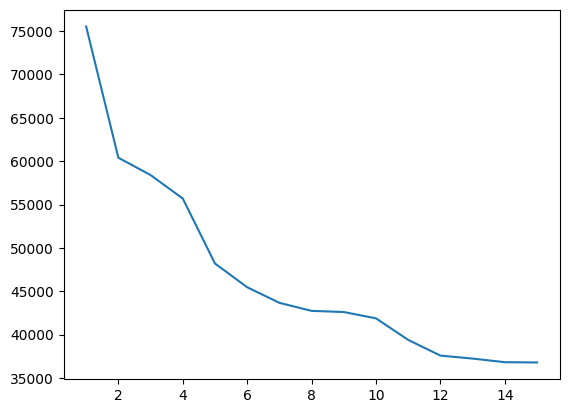

In [ ]:
#Elbow Plot
import matplotlib.pyplot as plt
y=np.array([i for i in range(1,16,1)])
plt.plot(y,costs)

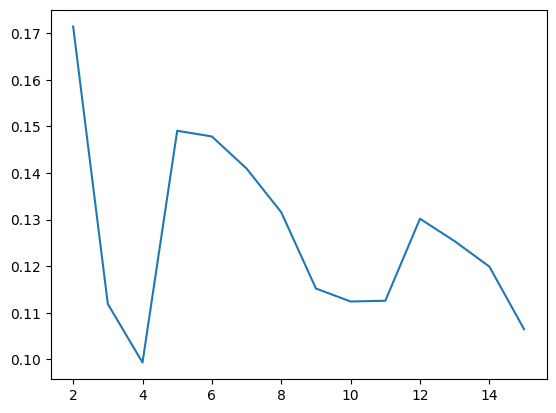

In [ ]:
#Silhouette Score
silhouette_scores=[]
for dataframe in list(dataframes.values())[1:]:
    dataframe_1=dataframe[["TDWKND", "STRTTIME_CAT", "NUMONTRP_CAT", "DWELTIME_CAT", "TRPMILES_CAT", "WHYTO_CAT", "TRIPPURP_CAT"]]
    temp_encoded_df=dataframe_1.apply(le.fit_transform)
    #dataframe["silhouette"]=silhouette_samples(temp_encoded_df, dataframe["CLUSTER"], metric="hamming")
    silhouette_scores.append(silhouette_score(temp_encoded_df, dataframe["CLUSTER"], metric="hamming", random_state=42))
x=np.arange(2,16,1)
plt.plot(x, silhouette_scores)

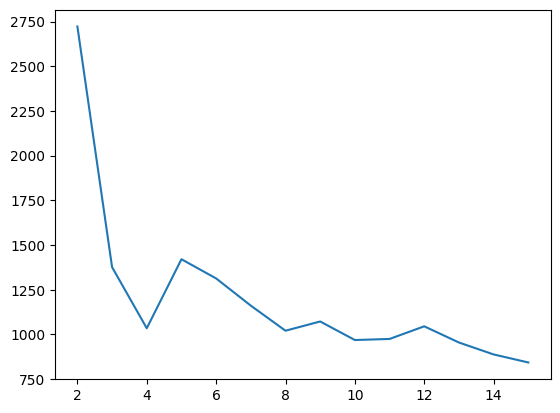

In [ ]:
#Calinski Harabasz Score
calinski_harabasz_scores=[]
for dataframe in list(dataframes.values())[1:]:
    dataframe_1=dataframe[["TDWKND", "STRTTIME_CAT", "NUMONTRP_CAT", "DWELTIME_CAT", "TRPMILES_CAT", "WHYTO_CAT", "TRIPPURP_CAT"]]
    temp_encoded_df=dataframe_1.apply(le.fit_transform)
    calinski_harabasz_scores.append(calinski_harabasz_score(temp_encoded_df, dataframe["CLUSTER"]))
x=np.arange(2,16,1)
plt.plot(x, calinski_harabasz_scores)

In [ ]:
def bic_score(dataframe, labels):
    """
    BIC score for the goodness of fit of clusters.
    This Python function is directly translated from the GoLang code made by the author of the paper.
    """
    varlist=["TDWKND", "STRTTIME_CAT", "NUMONTRP_CAT", "DWELTIME_CAT", "TRPMILES_CAT", "WHYTO_CAT", "TRIPPURP_CAT"]
    X=dataframe[varlist].apply(le.fit_transform)
    n_points = len(labels)
    n_clusters = len(set(labels))
    n_dimensions = X.shape[1]
    n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

    centroid_df = pd.DataFrame(centroids_encoded[n_clusters])
    #centroid_df.drop(7, axis=1, inplace=True)

    # sq_differences is an m x n matrix (m= number of clusters, n= number of observations)
    # Each row contains the distance of all observations from the mth cluster centroid.
    sq_differences=np.square((cdist(X, centroid_df, "hamming"))*n_dimensions).T
    loglikelihood = 0
    for label_name in labels.unique():
        X_cluster = dataframe[dataframe["CLUSTER"]==label_name]
        n_points_cluster = len(X_cluster)
        variance = np.sum(sq_differences[label_name-1]) / (len(X_cluster) - 1)
        loglikelihood += \
        n_points_cluster * np.log(n_points_cluster) \
        - n_points_cluster * np.log(n_points) \
        - n_points_cluster * n_dimensions / 2 * np.log(2 * math.pi * variance) \
        - (n_points_cluster - 1) / 2

    bic = loglikelihood - (n_parameters / 2) * np.log(n_points)

    return bic

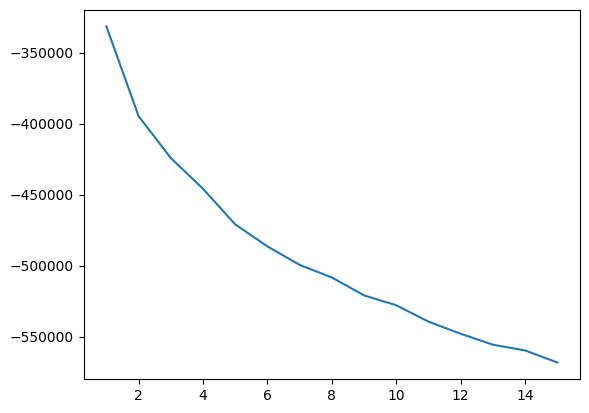

In [ ]:
#BIC score
BIC_score=[]
for dataframe in dataframes.values():
    BIC_score.append(bic_score(dataframe, dataframe["CLUSTER"]))

x=np.arange(1,16,1)
plt.plot(x,BIC_score)

#print(bic_score(dataframes[3], dataframes[3]["CLUSTER"]))

### Analyzing the clusters

In [ ]:
df_bestModel=dataframes[5]

In [ ]:
df_bestModel.columns

Index(['TDWKND', 'STRTTIME_CAT', 'NUMONTRP_CAT', 'DWELTIME_CAT',
       'TRPMILES_CAT', 'WHYTO_CAT', 'TRIPPURP_CAT', 'CLUSTER'],
      dtype='object')

In [ ]:
centroids_bestModel=defaultdict(list)
clusters=len(df_bestModel["CLUSTER"].unique())

for cluster in range(1,clusters+1):
    temp_df=df_bestModel[df_bestModel["CLUSTER"]==cluster]
    for variable in list(temp_df.columns[0:-1]):
        centroids_bestModel[cluster].append(statistics.mode(temp_df[variable]))

In [ ]:
df_centroids=pd.DataFrame(centroids_bestModel).T
df_centroids.columns=["Weekend/Weekday Trip", "Starting Time", "Number of Passengers", "Dwelling Time", "Trip Distance (Miles)", "Trip Purpose", "Home/Non-home based Trip"]
print("Cluster centroids")
df_centroids

Cluster centroids


,Weekend/Weekday Trip,Starting Time,Number of Passengers,Dwelling Time,Trip Distance (Miles),Trip Purpose,Home/Non-home based Trip
1,Weekday trip,10 AM - 3 PM,1 passenger,1-15 minutes,2-5 miles,Shopping & Dining,non-home based trip
2,Weekday trip,6 AM - 10 AM,1 passenger,More than 150 minutes,0-2 miles,Work,Home based trip
3,Weekday trip,3 PM - 7 PM,1 passenger,15-50 minutes,5-15 miles,Errands,Home based trip
4,Weekday trip,3 PM - 7 PM,2-4 passengers,50-150 minutes,15-1000 miles,Social & recreational,non-home based trip
5,Weekend trip,10 AM - 3 PM,2-4 passengers,50-150 minutes,5-15 miles,Shopping & Dining,Home based trip


[Text(0.5, 0, 'Trip cluster'), Text(0, 0.5, 'count')]

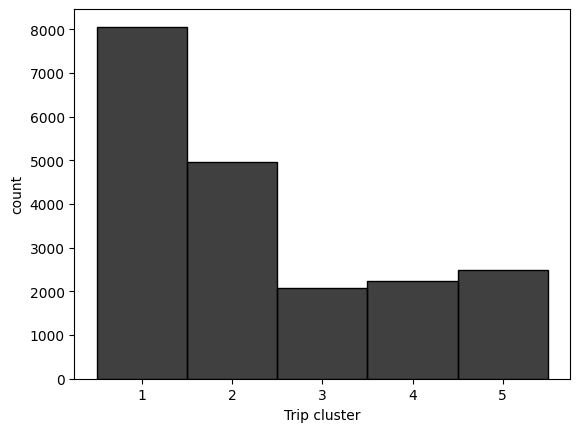

In [ ]:
fig=sns.histplot(data=df_bestModel, x="CLUSTER", discrete=True, color='black')
fig.set(xlabel="Trip cluster", ylabel="count")

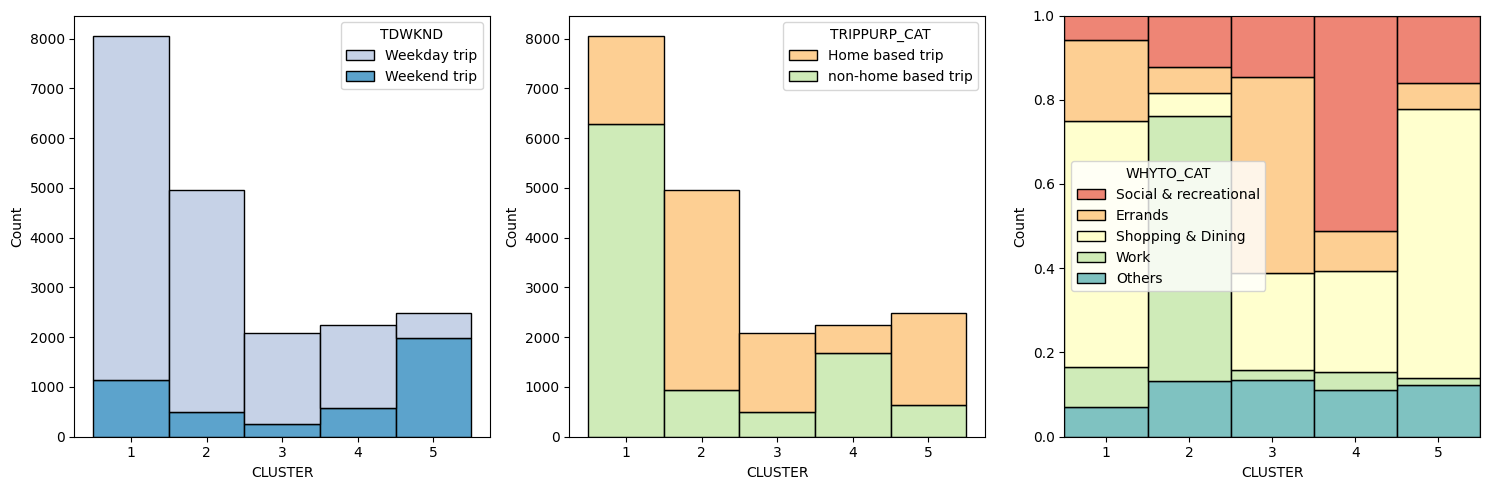

In [ ]:
f, axs = plt.subplots(1,3,figsize = (15,5))

sns.histplot(data=df_bestModel, x="CLUSTER", discrete=True, palette='PuBu', hue="TDWKND", multiple="stack", ax=axs[0])

sns.histplot(data=df_bestModel, x="CLUSTER", discrete=True, palette='Spectral', hue="TRIPPURP_CAT", multiple="stack", ax=axs[1])

sns.histplot(data=df_bestModel, x="CLUSTER", discrete=True, palette='Spectral', hue="WHYTO_CAT", multiple="fill", ax=axs[2])

plt.tight_layout()
plt.show()

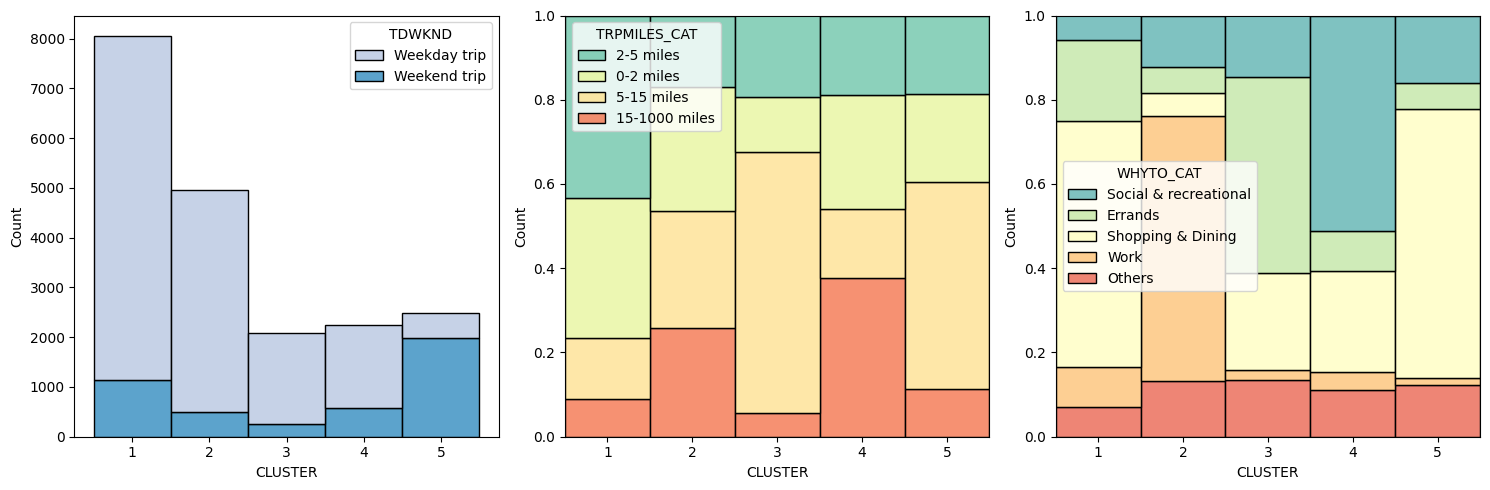

In [ ]:
f, axs=plt.subplots(1,3,figsize=(15,5))


sns.histplot(data=df_bestModel, x="CLUSTER", discrete=True, hue="TDWKND", palette="PuBu", multiple= "stack", ax=axs[0])

sns.histplot(data=df_bestModel, x="CLUSTER", discrete=True, hue="TRPMILES_CAT", palette="Spectral_r", multiple= "fill", ax=axs[1])

sns.histplot(data=df_bestModel, x="CLUSTER", discrete=True, hue="WHYTO_CAT", palette="Spectral_r", multiple= "fill", ax=axs[2])

plt.tight_layout()
plt.show()

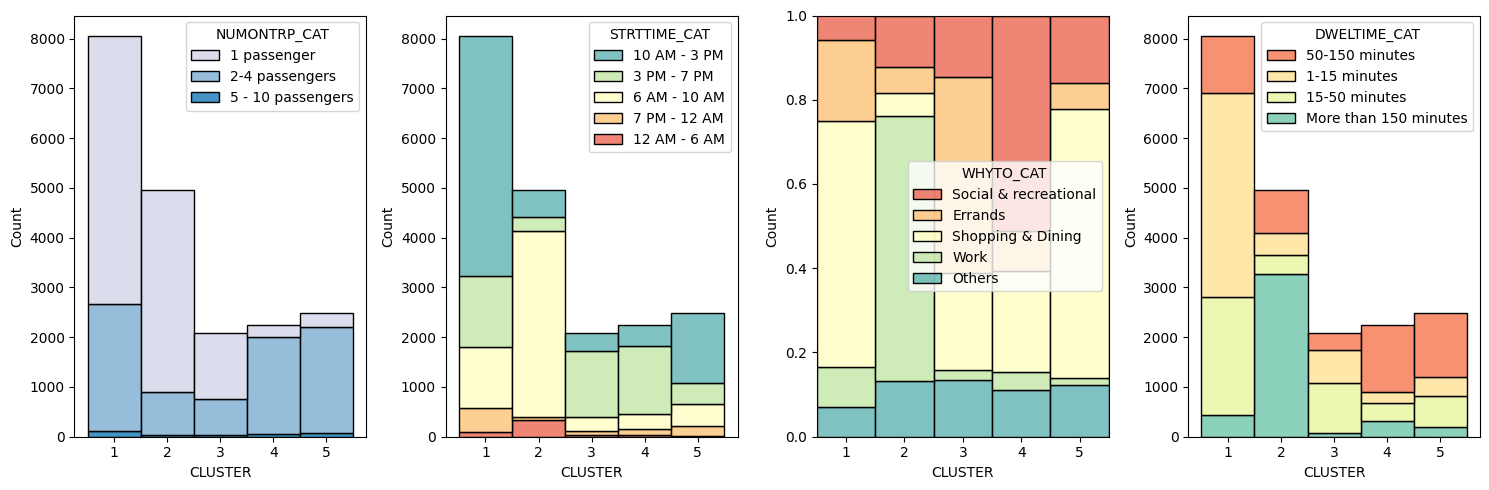

In [ ]:
f, axs = plt.subplots(1,4,figsize = (15,5))

sns.histplot(data=df_bestModel, x="CLUSTER", discrete=True, palette='PuBu', hue="NUMONTRP_CAT", multiple="stack", ax=axs[0])

sns.histplot(data=df_bestModel, x="CLUSTER", discrete=True, palette='Spectral_r', hue="STRTTIME_CAT", multiple="stack", ax=axs[1])

sns.histplot(data=df_bestModel, x="CLUSTER", discrete=True, palette='Spectral', hue="WHYTO_CAT", multiple="fill", ax=axs[2])

sns.histplot(data=df_bestModel, x="CLUSTER", discrete=True, hue="DWELTIME_CAT", palette="Spectral", multiple="stack", ax=axs[3])

plt.tight_layout()
plt.show()

### Exporting model outputs

In [ ]:
#Exporting the best model as the Random Forest Input
tree_input = pd.concat([df,dataframes[5][["CLUSTER"]]], axis=1)
tree_input = tree_input[['HOUSEID', 'TDTRPNUM', 'VEHID', 'PERSONID', 'HOMEOWN', 'HHSIZE', 'HHFAMINC', 'DRVRCNT', 'WRKCOUNT', 'YOUNGCHILD', 'LIF_CYC_CAT', 'R_AGE', 'EDUC', 'R_SEX', 'WORKER','HTPPOPDN', 'HTEEMPDN', 'HBPPOPDN', 'OTEEMPDN', 'OBPPOPDN',  'DTEEMPDN', 'DBPPOPDN', 'TDWKND', 'STRTTIME_CAT', 'TRIPPURP_CAT','WHYTO_CAT', 'DWELTIME_CAT', 'TRPMILES_CAT', 'NUMONTRP_CAT', 'CLUSTER', 'GASPRICE', 'GASPRICE_USD', 'FUELTYPE_BIN']]
path = "/content/drive/MyDrive/Work/EV_Preference_MachineLearning/Tree Input.csv"
tree_input.to_csv(path, index=False)